In [126]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.base import TransformerMixin

import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import os, sys, email,re
from sklearn.metrics import silhouette_score, silhouette_samples



[nltk_data] Downloading package stopwords to /home/ki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('../projectfinder.csv')
df.dropna(axis=0, inplace=True)
df.head()
#df.describe()

,skill_summary,title,description
0,"tableau, visualisierung",Business Intelligence Analyst (m/w) - Tableau ...,Business Intelligence Analyst (m/w) - Tableau ...
1,", implementierung, java, ms sql, camel, apache...",Developer - Talend ESB oder Apache Camel (m/w)...,"Konzeption, Customizing sowie Softwareanpassun..."
2,", windows, clients, ios, mobile devices, mobil...",IT-Mitarbeiter (m/w) 1st / 2nd Level Support /...,"Als Mitglied eines kleinen, dynamischen Teams ..."
3,"dynamics ax 2009, dynamics crm 4.0, dynamics a...",Consultant für Microsoft Dynamics CRM (m/w),Über unseren Kunden: \n \n Unser Kunde ist e...
4,"hibernate, java, deutsch, oracle 11g, oracle 1...",Java Senior Developer - Backend (f/m),Über unseren Kunden: \n \n Unser Kunde ist e...


In [4]:
#split features
title = df['title']
description = df['description']
skill = df['skill_summary']

In [5]:
# load nltk's German stopwords'
with open('../stopwords-de.txt', 'r') as f:
    stopwords_germ = f.read().splitlines()

stopwords_eng = nltk.corpus.stopwords.words('english')
extra = ['bewerben', 'direkt', 'melden', 'www', 'contactor', 'erfahrung', 'kenntnisse']
stopwords = stopwords_germ + stopwords_eng + extra


In [59]:
# load nltk's SnowballStemmer
from nltk.stem.snowball import SnowballStemmer
stemmer_eng = SnowballStemmer("english")
stemmer_germ = SnowballStemmer("german")

In [100]:
def clean_and_stem(word):
    clean_word = str(word).replace('[','').replace(']','').replace("'", "")
    #stemming lowers also
    eng_stem = stemmer_eng.stem(clean_word)
    germ_stem= stemmer_germ.stem(eng_stem)
    return germ_stem


In [104]:
def get_optimal_data(df):
    #split features
    col = [col for col in df.columns]
    combined = df[col[0]] + ' '  + df[col[1]] + ' '  + df[col[2]]
    combined_tolist = [item.split() for item in combined]
    combined_cleaned = [clean_and_stem(word) for word in combined_tolist]
    return combined_cleaned

5360

In [111]:
vectorizer = CountVectorizer(stop_words=stopwords,ngram_range=(1, 1))
tfidf = TfidfVectorizer(stop_words=stopwords,ngram_range=(1, 2))
#X = vectorizer.fit_transform(chi)
B = tfidf.fit_transform(combined_cleaned)
B.shape

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wahr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(5360, 262629)

In [115]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
model.fit(B)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=4, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [116]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
order_centroids
#terms


array([[198132,   8301,  92812, ..., 164859, 164858, 131314],
       [ 87959,  58736, 128707, ..., 163990, 163987, 131314],
       [ 55674, 112358,  55677, ..., 173165, 173164,      0],
       [123028,  79389,  80326, ...,  85241, 180420, 227247]])

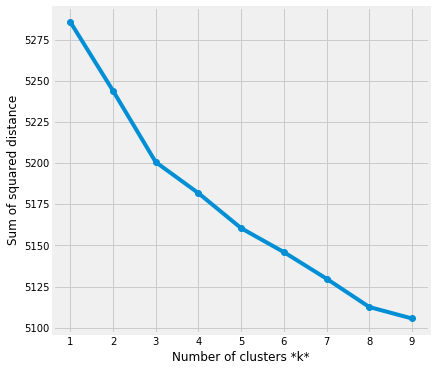

In [124]:
#Finding optimal number of clusters using Elbow
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(B)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

ValueError: 'c' argument has 5360 elements, which is not acceptable for use with 'x' with size 1, 'y' with size 1.

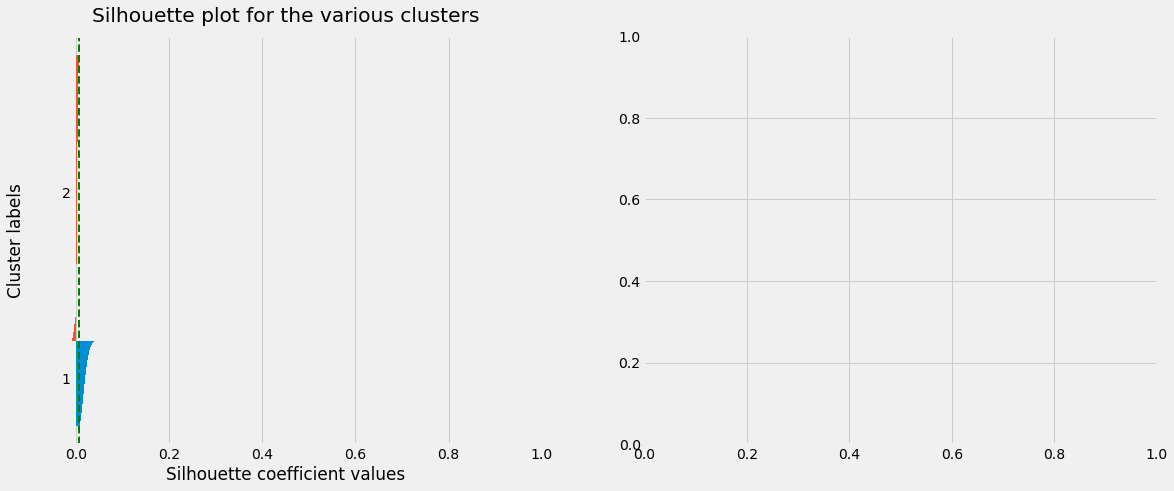

In [131]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(B)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(B, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(np.reshape(B[:, 0],-1), np.reshape(B[:, 1],-1), c=np.reshape(labels,-1))
    #ax2.scatter(B[:, 0], B[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

IndentationError: unexpected indent (<ipython-input-130-38fd3caad9f1>, line 2)

AttributeError: 'KMeans' object has no attribute 'labels'

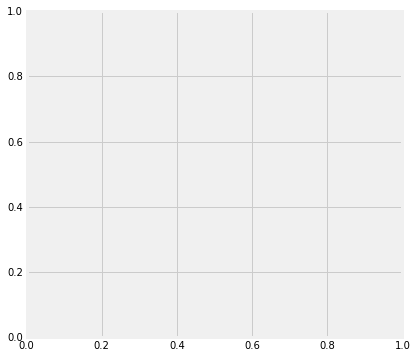

In [125]:
# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(B[model.labels == 0, 0], B[model.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(B[km.labels == 1, 0], B[model.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('Eruption time in mins')
plt.ylabel('Waiting time to next eruption')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

In [ ]:
for i in range(true_k):
    print()
    print(f'Cluster {i}')
    
    for ind in order_centroids[i, :10]:
        print(terms[ind])

In [121]:

def evaluate_kmeans(X, model, metric='euclidean'):
    """ Evaluate a K-Means model that has been trained on X using the
     Silhouette score.

    Args:
        X: the TF-IDF matrix where each line represents a document and each
           column represents a word, typically obtained by running
           transform_text() from the TP2.
        model: the KMeans model trained on X.
    Returns:
        A double that corresponds to the Silhouette score of the model.
    """
    return silhouette_score(X, model.labels_)

In [122]:
evaluate_kmeans(B, model)

0.009520793678100435

# Trial and Errors

In [35]:
title_pipe = make_pipeline(
       DataFrameColumnExtracter('title'), 
       CountVectorizer(ngram_range=(1, 2), analyzer='word', stop_words=stopwords)
)

desc_pipe = make_pipeline(
       DataFrameColumnExtracter('description'), 
       CountVectorizer(ngram_range=(1, 2), analyzer='word', stop_words=stopwords)
)

skill_pipe = make_pipeline(
       DataFrameColumnExtracter('skill_summary'), 
       CountVectorizer(ngram_range=(1, 2), analyzer='word', stop_words=stopwords)
)


In [48]:
 sparse_matrix_of_counts = feature_union.fit_transform(df)
